# Grammianos ponderados entre subespacios ligand-free (lf), ligand-bound (lb) y subespacios de la dinámica de no equilibrio.
## No leo las matrices originales, sino las q ya están ordenadas, en "min_cost_assigned_full"

In [98]:
using DataFrames
using Gadfly
using Cairo
using Distributions
set_default_plot_size(40cm, 14cm)

In [99]:
function tognm(vtor_anm)
    vtor_gnm = Array{Float64}(convert(Int64, length(vtor_anm)/3));
    vtor_anm =  vtor_anm.^2
    for i=1:convert(Int64, length(vtor_anm)/3)
        vtor_gnm[i] = sqrt(vtor_anm[i*3-2] + vtor_anm[i*3-1] + vtor_anm[i*3])
    end
    return vtor_gnm
end

tognm (generic function with 1 method)

In [100]:
function read_ptraj_modes(file, modes_elements, nmodes::Int64=0, norma::Bool=true)    

    modes_file=open(file, "r")
    modes_text = readdlm(modes_file, skipstart=0, skipblanks=true, 
    comments=true, comment_char='\*')
    close(modes_file)

    if nmodes == 0
        nmodes = modes_text[1, 5]
    end
    ncoords = convert(Int64, modes_elements)
    lines = ceil(Int64, ncoords/7)
    rest = convert(Int64, ncoords % 7)
    
    eval=Array{Float64}(nmodes);
    mode = Array{Float64}(ncoords, nmodes);
    temp1=Array{Float64}(ncoords, 1);
    temp2 = Array{Float64}(ncoords+(7-rest));

    j=lines + 1 + 2 # 1 p/ q lea la prox linea 2 por el header

    for i=1:nmodes
        eval[i] = modes_text[j, 2]
        temp = permutedims(modes_text[(j+1):(lines+j), :], [2, 1])
        temp2 = reshape(temp, ncoords+(7-rest))
        for k=(rest+1):7
            pop!(temp2)
        end
    mode[:, i] = temp2
        j = j + lines + 1
    end
    
    if norma == true
        for i=1:nmodes
            mode[: ,i] = mode[:, i] / norm(mode[:, i])
        end
    end
    
    return mode, eval
end

read_ptraj_modes (generic function with 3 methods)

In [101]:
function WeightedHist(in_vec, in_bins, in_weight, density = false)
    # Safety check    
    if length(in_vec) != length(in_weight)
        println("Each element of the input vector needs one weight")
        return
    end
    
    # Prepare variables
    out_counts = Array{Float64}(length(in_bins)-1)
    
    # Get weighted histogram
    for i=1:length(in_bins)-1
        temp_bool = (in_vec .>= in_bins[i]) & (in_vec .< in_bins[i+1])
        out_counts[i] = sum(in_weight[temp_bool])
    end
    
    # Get bins middle points
    out_middle = (in_bins[1:end-1] + in_bins[2:end]) / 2
    
    # Turn counts into density
    if (density == true)
        out_counts = out_counts ./ sum(out_counts) 
    end
    return out_counts, out_middle
end

WeightedHist (generic function with 2 methods)

In [102]:
function qgrammian0(mtx_1, mtx_2, weight_1 = 0)
    # Projects mtx_1 onto mtx_2 and gets the mean of the elements in the diagonal.
    if size(mtx_1)[1] != size(mtx_2)[1]
        println("Length of matrices columns must be the same. Aborting.")
        return 0
    end
    
    mtx_g = transpose(mtx_1) * mtx_2 * transpose(mtx_2) * mtx_1
      
    if weight_1 != 0
        # Weights were specified
        if length(weight_1) != size(mtx_1)[2]
            println("There must be as many weights as columns. Aborting.")
            return 0
        end
        weighted = diag(mtx_g) .* weight_1
        zeta = sum(weighted)
    else
        zeta = mean(diag(mtx_g))   
    end
    
    
    return zeta
end

qgrammian0 (generic function with 2 methods)

In [103]:
function qgrammian1(mtx_1, mtx_2, weight_1 = 0, weight_2 = 0)
    # Projects mtx_1 onto mtx_2 and gets the mean of the elements in the diagonal.
    if size(mtx_1)[1] != size(mtx_2)[1]
        println("Length of matrices columns must be the same. Aborting.")
        return 0
    end
    
    if weight_1 != 0 && weight_2 != 0
        # Weights were specified
        if length(weight_1) != size(mtx_1)[2] || length(weight_2) != size(mtx_2)[2]
            println("There must be as many weights as columns. Aborting.")
            return 0
        end
        mtx_1 = mtx_1 * diagm(weight_1)
        mtx_2 = mtx_2 * diagm(weight_2)
    end
    
    mtx_g = transpose(mtx_1) * mtx_2 * transpose(mtx_2) * mtx_1
    zeta = mean(diag(mtx_g))
    
    return zeta
end

qgrammian1 (generic function with 3 methods)

In [104]:
function grammian(mtx_1, mtx_2, weight_1 = 0, weight_2 = 0)
mtx_1 = lf_modes
mtx_2 = lb_modes
weight_1 = 0
weight_2 = 0

    # Projects mtx_1 onto mtx_2 and gets the mean of the elements in the diagonal.
    if size(mtx_1)[1] != size(mtx_2)[1]
        println("Length of matrices columns must be the same. Aborting.")
        return 0
    end
    
    if weight_1 != 0 && weight_2 != 0
        # Weights were specified
        if length(weight_1) != size(mtx_1)[2] || length(weight_2) != size(mtx_2)[2]
            println("There must be as many weights as columns. Aborting.")
            return 0
        end
        mtx_1 = mtx_1 * diagm(weight_1)
        mtx_2 = mtx_2 * diagm(weight_2)
    end
    
    mtx_p = transpose(mtx_1) * mtx_2 * transpose(mtx_2) * mtx_1
    eival, eivec = eig(mtx_g)
    
    return mean(eival)
end

grammian (generic function with 3 methods)

### Hago

In [105]:
# Preparo variables
aa = 101
aa3 = aa * 3
aa3_6 = aa3 - 6
n_frames = 401
boot_count = 800
main_dir = "/home/german/labo/16/pdz_gramm/short/"
LfLb_dir = "analyze_qha_ca/"
neq_dir = "lb_dats/"
neq_modes_dir = "vecs/"
min_cost_modes_dir = "min_cost_assigned_20/"
boot_dir= "boot_mtces/"
rtdos_dir = "rtdos_log/"

neq_pond_template = "-lbnoteq_ca_mode_freq_nohist.dat"       # ej: "1" * neq_pond_template
neq_subspSize_template = "-lbnoteq_ca_subspace_countk.dat"   # ej: "1" * neq_subspSize_template
neq_modes_template = "lb_prod_vecs_ca_"                      # ej: neq_modes_template * "1" * ".dat"

# Leo indices de los modos de los subespacios ligand free y bound
lf_indices = readdlm(string(main_dir, LfLb_dir, "lf_prod_ca_subspace_countk.dat"));
lf_indices = convert(Array{Int64,1}, reshape(lf_indices, length(lf_indices)))
lf_indices = sort(lf_indices)
lb_indices = readdlm(string(main_dir, LfLb_dir, "lb_prod_ca_subspace_countk.dat"));
lb_indices = convert(Array{Int64,1}, reshape(lb_indices, length(lb_indices)))
lb_indices = sort(lb_indices)

# Leo y normalizo los pesos de los modos lf y lb
lf_pond = readdlm(string(main_dir, LfLb_dir, "lf_prod_ca_mode_freq_nohist.dat"))[lf_indices, 2]
lf_pond = lf_pond / sum(lf_pond)
lb_pond = readdlm(string(main_dir, LfLb_dir, "lb_prod_ca_mode_freq_nohist.dat"))[lb_indices, 2]
lb_pond = lb_pond / sum(lb_pond)

# Leo modos lf y lb
# lf
lf_modes, lf_eigen = read_ptraj_modes(string(main_dir, LfLb_dir, "lf_prod_vecs_ca.dat"), aa3, aa3_6)
lf_modes = lf_modes[:, lf_indices]
lf_eigen = lf_eigen[lf_indices]
# lb
lb_modes, lb_eigen = read_ptraj_modes(string(main_dir, LfLb_dir, "lb_prod_vecs_ca.dat"), aa3, aa3_6)
lb_modes = lb_modes[:, lb_indices]
lb_eigen = lb_eigen[lb_indices];

In [106]:
gramm_lf_neq = Array{Float64, 1}(n_frames)
gramm_lb_neq = Array{Float64, 1}(n_frames)
Wgramm_lf_neq = Array{Float64, 1}(n_frames)
Wgramm_lb_neq = Array{Float64, 1}(n_frames)
WWgramm_lf_neq = Array{Float64, 1}(n_frames)
WWgramm_lb_neq = Array{Float64, 1}(n_frames)
neq_modes_list = Array{Array{Float64, 2}, 1}(n_frames)
neq_eigen_list = Array{Array{Float64, 1}, 1}(n_frames)
neq_pond_list = Array{Array{Float64, 1}, 1}(n_frames)

for i in 1:n_frames
    k = i - 1
    pond_file = open(string(main_dir, min_cost_modes_dir, "neq_pond_frame_", k), "r")
    indices_file = open(string(main_dir, neq_dir, k, neq_subspSize_template), "r")
    modes_filename = string(main_dir,min_cost_modes_dir,"neq_mode_frame_", k)
    eigen_filename = string(main_dir,min_cost_modes_dir,"neq_eigen_frame_", k)

    # Get the indices of the modes of the current subspace
    neq_indices = readdlm(indices_file);
    neq_indices = convert(Array{Int64,1}, reshape(neq_indices, length(neq_indices)))
    neq_indices = sort(neq_indices)

    # Get the coefficients for the ponderation. They are already sorted according to neq_indices.
    neq_pond = readdlm(pond_file)[1:length(neq_indices)];
    neq_pond = neq_pond / sum(neq_pond)

    # Get the modes/eigenvalues of the current subspace
    neq_modes = readdlm(modes_filename)[:, neq_indices]
    neq_eigen = readdlm(eigen_filename)[neq_indices]

    # Store the current modes, eigenvalues and weights
    neq_modes_list[i] = neq_modes
    neq_eigen_list[i] = neq_eigen
    neq_pond_list[i] = neq_pond
    
    # Grammiano
    gramm_lf_neq[i] = qgrammian0(neq_modes, lf_modes)
    gramm_lb_neq[i] = qgrammian0(neq_modes, lb_modes)
    
    # Grammiano ponderado
    Wgramm_lf_neq[i] = qgrammian1(neq_modes, lf_modes, neq_pond, lf_pond)
    Wgramm_lb_neq[i] = qgrammian1(neq_modes, lb_modes, neq_pond, lb_pond)
    
    # Verdadera ponderación 
    WWgramm_lf_neq[i] = qgrammian0(neq_modes, lf_modes, neq_pond)
    WWgramm_lb_neq[i] = qgrammian0(neq_modes, lb_modes, neq_pond)
end

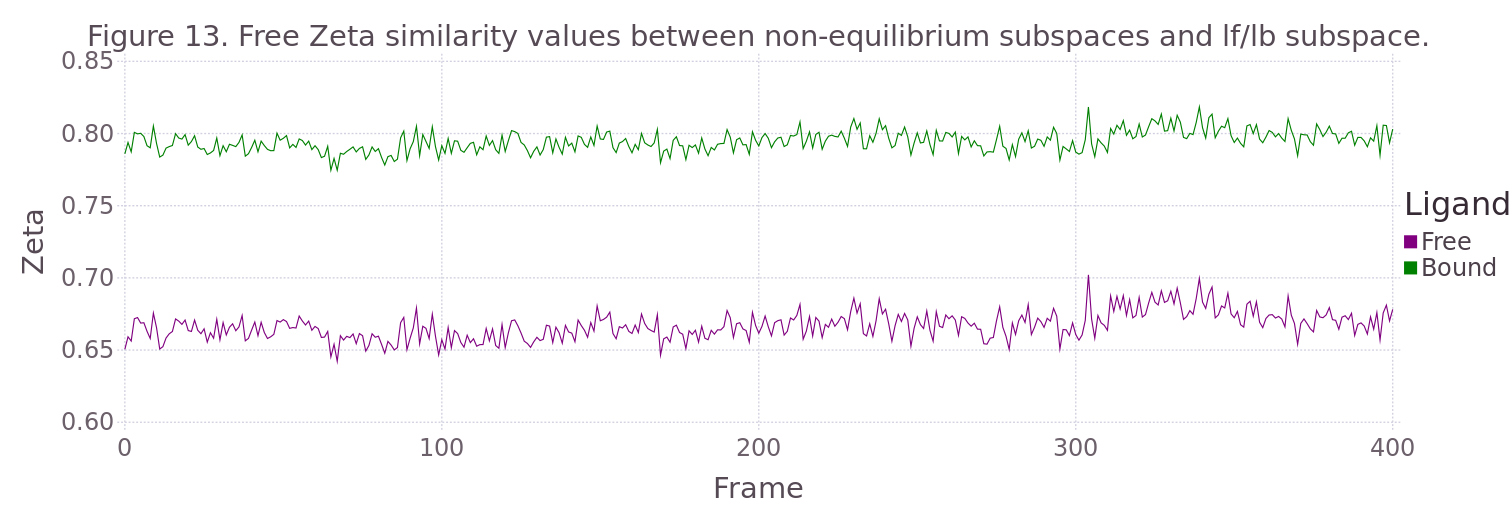

In [107]:
# Compila todo en un dataframe
df_gramm_neq_lf_lb = DataFrame(Zeta = [ gramm_lf_neq; gramm_lb_neq ], Ligand = repeat(["Free"; "Bound"], inner = n_frames),
Frame = [ collect(0:n_frames-1) ; collect(0:n_frames-1)])

# Plot
pdf_gramm_neq_lf_lb = plot(df_gramm_neq_lf_lb, x="Frame", y="Zeta", color = "Ligand", Geom.line,
Guide.title("Figure 13. Free Zeta similarity values between non-equilibrium subspaces and lf/lb subspace."),
Scale.color_discrete_manual(colorant"purple", colorant"green"),
Theme(grid_line_width=1pt, 
minor_label_font_size = 18pt, major_label_font_size = 22pt, key_title_font_size = 24pt,
key_label_font_size = 18pt))

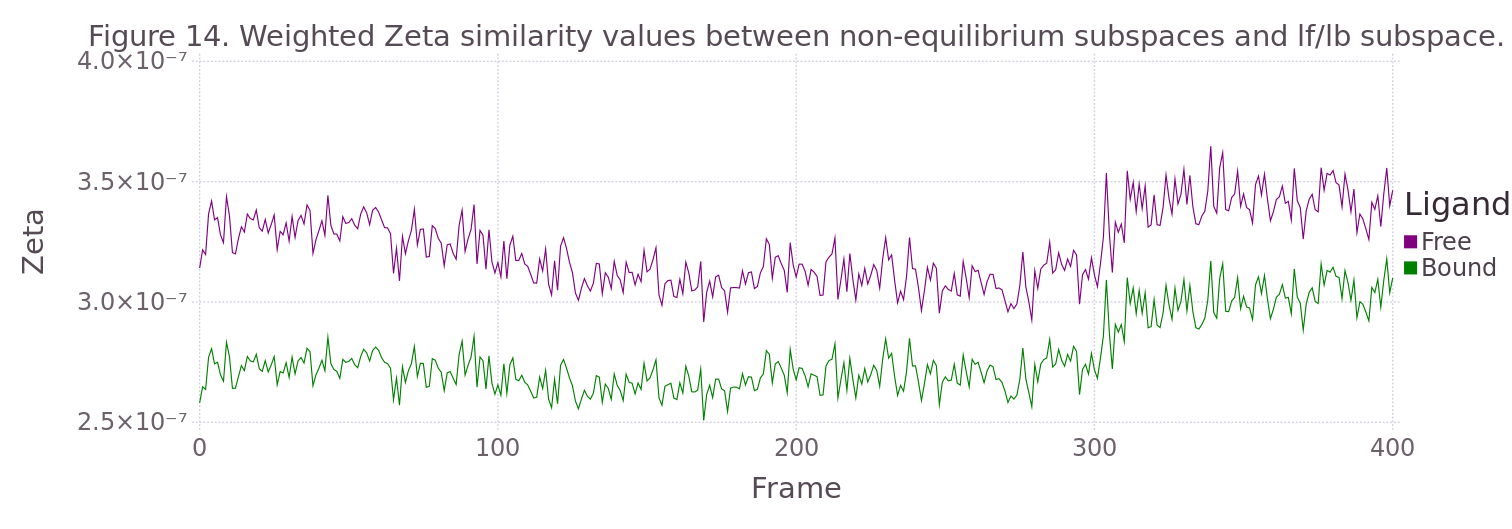

In [108]:
# Compila todo en un dataframe
df_Wgramm_neq_lf_lb = DataFrame(Zeta = [ Wgramm_lf_neq; Wgramm_lb_neq ], Ligand = repeat(["Free"; "Bound"], inner = n_frames),
Frame = [ collect(0:n_frames-1) ; collect(0:n_frames-1)])

# Plot
pdf_Wgramm_neq_lf_lb = plot(df_Wgramm_neq_lf_lb, x="Frame", y="Zeta", color = "Ligand", Geom.line,
Guide.title("Figure 14. Weighted Zeta similarity values between non-equilibrium subspaces and lf/lb subspace."),
Scale.color_discrete_manual(colorant"purple", colorant"green"),
Theme( grid_line_width=1pt,
minor_label_font_size = 18pt, major_label_font_size = 22pt, key_title_font_size = 24pt,
key_label_font_size = 18pt))

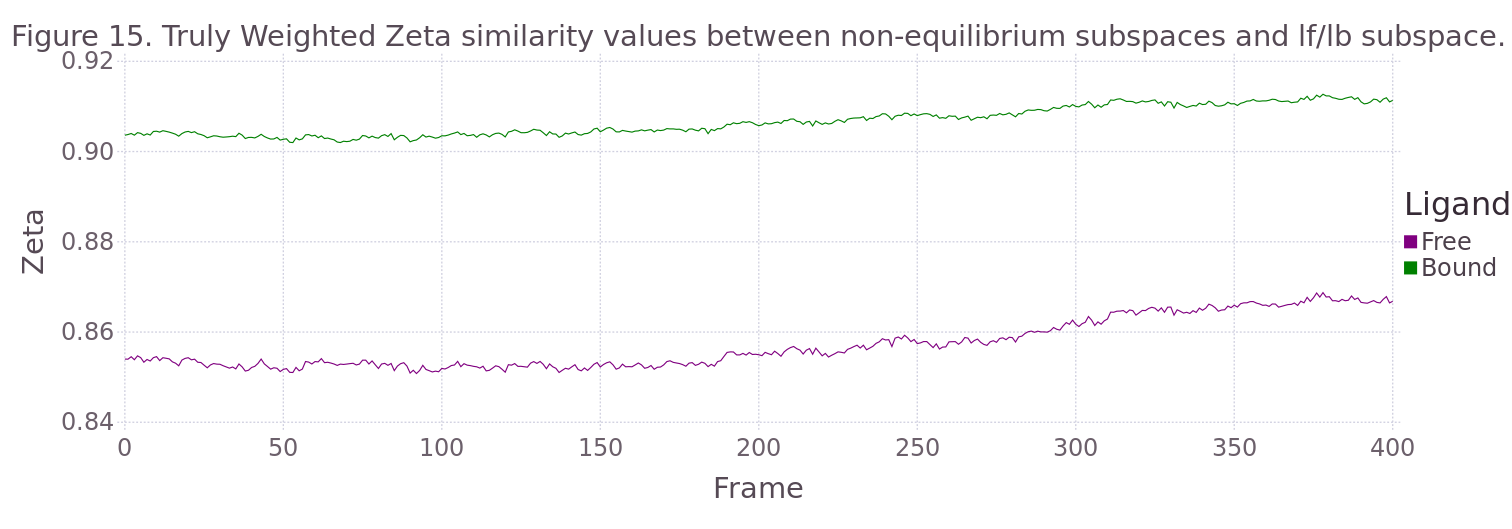

In [109]:
# Compila todo en un dataframe
df_WWgramm_neq_lf_lb = DataFrame(Zeta = [ WWgramm_lf_neq; WWgramm_lb_neq ], Ligand = repeat(["Free"; "Bound"], inner = n_frames),
Frame = [ collect(0:n_frames-1) ; collect(0:n_frames-1)])

# Plot
pdf_Wgramm_neq_lf_lb = plot(df_WWgramm_neq_lf_lb, x="Frame", y="Zeta", color = "Ligand", Geom.line,
Guide.title("Figure 15. Truly Weighted Zeta similarity values between non-equilibrium subspaces and lf/lb subspace."),
Scale.color_discrete_manual(colorant"purple", colorant"green"),
Guide.xticks(ticks=collect(0:50:400)),
Theme( grid_line_width=1pt,
minor_label_font_size = 18pt, major_label_font_size = 22pt, key_title_font_size = 24pt,
key_label_font_size = 18pt))

# Ahora obtengo, p/ c/ frame, una distribución de zeta values a partir de matrices reordenadas de la matriz de modos de no equilibrio

### 1: obtengo las matrices reordenadas. Hacer esto por única vez.

reord_count = 500
template = collect(-10:10)

gramm_lf_reord = zeros(Float64, reord_count, n_frames)
gramm_lb_reord = zeros(Float64, reord_count, n_frames)
Wgramm_lf_reord = zeros(Float64, reord_count, n_frames)
Wgramm_lb_reord = zeros(Float64, reord_count, n_frames)
WWgramm_lf_reord = zeros(Float64, reord_count, n_frames)
WWgramm_lb_reord = zeros(Float64, reord_count, n_frames)
WWgramm_lf_reord_rnd = zeros(Float64, reord_count, n_frames)
WWgramm_lb_reord_rnd = zeros(Float64, reord_count, n_frames)

for i in 1:n_frames
    k = i - 1
    println("Frame: ", k)
    # Filenames
    indices_file = open(string(main_dir, neq_dir, k, neq_subspSize_template), "r")
    modes_filename = string(main_dir, neq_modes_dir, neq_modes_template, k, ".dat")

    # Get the indices of the modes of the current subspace
    neq_indices = readdlm(indices_file);
    neq_indices = convert(Array{Int64,1}, reshape(neq_indices, length(neq_indices)))
    neq_indices = sort(neq_indices)

    # Get the modes/eigenvalues of the current subspace
    neq_modes, neq_eigen = read_ptraj_modes(modes_filename, aa3);

    for j in 1:reord_count
        # Randomize indices and reorder the neq matrices
        k = 0
        reord_neq_modes = Array{Float64, 2}(aa3, length(neq_indices))
        for ii in neq_indices
            k += 1
            pre_mask = ii .+ template
            mask = pre_mask[!((pre_mask .< 1) | (pre_mask .> aa3_6))]    
            reord_neq_modes[:, k] = neq_modes[:, rand(mask)]
        end

        #### Ahora obtengo las distribuciones con las matrices reordenadas
        reord_mtx = reord_neq_modes;
        
        # Grammiano
        gramm_lf_reord[j, i] = qgrammian0(reord_mtx, lf_modes)
        gramm_lb_reord[j, i] = qgrammian0(reord_mtx, lb_modes)
    
        # Grammiano ponderado
        Wgramm_lf_reord[j, i] = qgrammian1(reord_mtx, lf_modes, neq_pond_list[i], lf_pond)
        Wgramm_lb_reord[j, i] = qgrammian1(reord_mtx, lb_modes, neq_pond_list[i], lb_pond)
        
        # Verdadera ponderación 
        WWgramm_lf_reord[j, i] = qgrammian0(reord_mtx, lf_modes, neq_pond_list[i])
        WWgramm_lb_reord[j, i] = qgrammian0(reord_mtx, lb_modes, neq_pond_list[i])
        
        # Verdadera ponderación random
        rnd_weights = abs(randn(length(neq_pond_list[i])))
        rnd_weights = rnd_weights / sum(rnd_weights)
        WWgramm_lf_reord_rnd[j, i] = qgrammian0(reord_mtx, lf_modes, rnd_weights)
        
        rnd_weights = abs(randn(length(neq_pond_list[i])))
        rnd_weights = rnd_weights / sum(rnd_weights)
        WWgramm_lb_reord_rnd[j, i] = qgrammian0(reord_mtx, lb_modes, rnd_weights)
        
    end
#end

# Ahora guardo resultados
writedlm(string(main_dir, rtdos_dir, "1gramm_lf_reord_1"), gramm_lf_reord)
writedlm(string(main_dir, rtdos_dir, "1gramm_lb_reord_1"), gramm_lb_reord)
writedlm(string(main_dir, rtdos_dir, "1Wgramm_lf_reord_1"), Wgramm_lf_reord)
writedlm(string(main_dir, rtdos_dir, "1Wgramm_lb_reord_1"), Wgramm_lb_reord)
writedlm(string(main_dir, rtdos_dir, "1WWgramm_lf_reord_1"), WWgramm_lf_reord)
writedlm(string(main_dir, rtdos_dir, "1WWgramm_lb_reord_1"), WWgramm_lb_reord)
writedlm(string(main_dir, rtdos_dir, "1WWgramm_lf_reord_rnd_1"), WWgramm_lf_reord_rnd)
writedlm(string(main_dir, rtdos_dir, "1WWgramm_lb_reord_rnd_1"), WWgramm_lb_reord_rnd)

# Ahora guardo resultados
writedlm(string(main_dir, rtdos_dir, "gramm_lf_reord_2"), gramm_lf_reord)
writedlm(string(main_dir, rtdos_dir, "gramm_lb_reord_2"), gramm_lb_reord)
writedlm(string(main_dir, rtdos_dir, "Wgramm_lf_reord_2"), Wgramm_lf_reord)
writedlm(string(main_dir, rtdos_dir, "Wgramm_lb_reord_2"), Wgramm_lb_reord)
writedlm(string(main_dir, rtdos_dir, "WWgramm_lf_reord_2"), WWgramm_lf_reord)
writedlm(string(main_dir, rtdos_dir, "WWgramm_lb_reord_2"), WWgramm_lb_reord)
writedlm(string(main_dir, rtdos_dir, "WWgramm_lf_reord_rnd_2"), WWgramm_lf_reord_rnd)
writedlm(string(main_dir, rtdos_dir, "WWgramm_lb_reord_rnd_2"), WWgramm_lb_reord_rnd)

----------------------

### Ahora uso las distribuciones ya generadas.

In [110]:
# Read previously obtained distributions
gramm_lf_reord = readdlm(string(main_dir, rtdos_dir, "gramm_lf_reord_1"))
gramm_lb_reord = readdlm(string(main_dir, rtdos_dir, "gramm_lb_reord_1"))
Wgramm_lf_reord = readdlm(string(main_dir, rtdos_dir, "Wgramm_lf_reord_1"))
Wgramm_lb_reord = readdlm(string(main_dir, rtdos_dir, "Wgramm_lb_reord_1"))
WWgramm_lf_reord = readdlm(string(main_dir, rtdos_dir, "WWgramm_lf_reord_1"))
WWgramm_lb_reord = readdlm(string(main_dir, rtdos_dir, "WWgramm_lb_reord_1"))
WWgramm_lf_reord_rnd = readdlm(string(main_dir, rtdos_dir, "WWgramm_lf_reord_rnd_1"))
WWgramm_lb_reord_rnd = readdlm(string(main_dir, rtdos_dir, "WWgramm_lb_reord_rnd_1"));

gramm_lf_reord = [ gramm_lf_reord ; readdlm(string(main_dir, rtdos_dir, "gramm_lf_reord_2")) ]
gramm_lb_reord = [ gramm_lb_reord ; readdlm(string(main_dir, rtdos_dir, "gramm_lb_reord_2")) ]
Wgramm_lf_reord = [ Wgramm_lf_reord ; readdlm(string(main_dir, rtdos_dir, "Wgramm_lf_reord_2")) ]
Wgramm_lb_reord = [ Wgramm_lb_reord ; readdlm(string(main_dir, rtdos_dir, "Wgramm_lb_reord_2")) ]
WWgramm_lf_reord = [ WWgramm_lf_reord ; readdlm(string(main_dir, rtdos_dir, "WWgramm_lf_reord_2")) ]
WWgramm_lb_reord = [ WWgramm_lb_reord ; readdlm(string(main_dir, rtdos_dir, "WWgramm_lb_reord_2")) ]
WWgramm_lf_reord_rnd = [ WWgramm_lf_reord_rnd ; readdlm(string(main_dir, rtdos_dir, "WWgramm_lf_reord_rnd_2")) ]
WWgramm_lb_reord_rnd = [ WWgramm_lb_reord_rnd ; readdlm(string(main_dir, rtdos_dir, "WWgramm_lb_reord_rnd_2")) ];

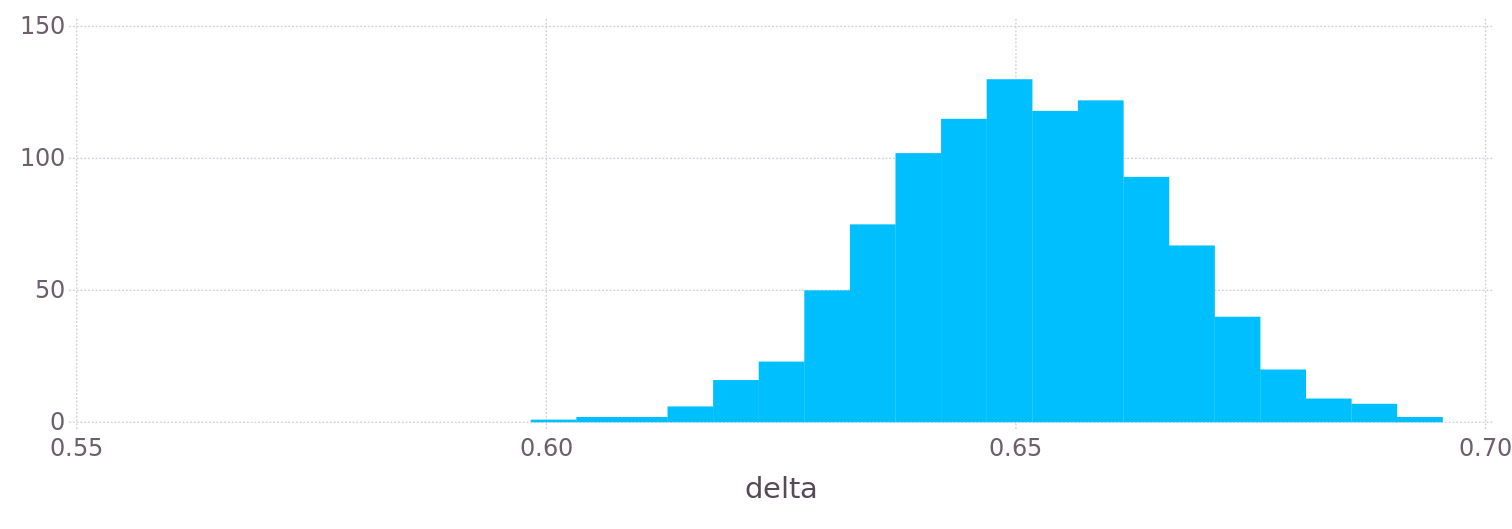

In [111]:
# Check normality
plot(DataFrame(delta = WWgramm_lf_reord_rnd[:, 1]), x="delta", Geom.histogram(bincount=20),
Theme( grid_line_width=1pt,
minor_label_font_size = 18pt, major_label_font_size = 22pt, key_title_font_size = 24pt,
key_label_font_size = 18pt))

In [112]:
std_dev_gramm_lf = Array{Float64, 1}(n_frames)
std_dev_gramm_lb = Array{Float64, 1}(n_frames)
std_dev_Wgramm_lf = Array{Float64, 1}(n_frames)
std_dev_Wgramm_lb = Array{Float64, 1}(n_frames)
std_dev_WWgramm_lf = Array{Float64, 1}(n_frames)
std_dev_WWgramm_lb = Array{Float64, 1}(n_frames)
std_dev_WWgramm_lf_rnd = Array{Float64, 1}(n_frames)
std_dev_WWgramm_lb_rnd = Array{Float64, 1}(n_frames)


# Get the means of the reordstrapp distributions
means_gramm_lf_reord = mapslices(x->mean(x), gramm_lf_reord, 1)
means_gramm_lb_reord = mapslices(x->mean(x), gramm_lb_reord, 1)
means_Wgramm_lf_reord = mapslices(x->mean(x), Wgramm_lf_reord, 1)
means_Wgramm_lb_reord = mapslices(x->mean(x), Wgramm_lb_reord, 1)
means_WWgramm_lf_reord = mapslices(x->mean(x), WWgramm_lf_reord, 1)
means_WWgramm_lb_reord = mapslices(x->mean(x), WWgramm_lb_reord, 1)
means_WWgramm_lf_reord_rnd = mapslices(x->mean(x), WWgramm_lf_reord_rnd, 1)
means_WWgramm_lb_reord_rnd = mapslices(x->mean(x), WWgramm_lb_reord_rnd, 1)

# Get the standard deviations of the reordstrapp distributions
for i in 1:n_frames
    std_dev_gramm_lf[i] = sum((gramm_lf_reord[:, i] .- means_gramm_lf_reord[i]) .^ 2)
    std_dev_gramm_lb[i] = sum((gramm_lb_reord[:, i] .- means_gramm_lb_reord[i]) .^ 2)
    std_dev_Wgramm_lf[i] = sum((Wgramm_lf_reord[:, i] .- means_Wgramm_lf_reord[i]) .^ 2)
    std_dev_Wgramm_lb[i] = sum((Wgramm_lb_reord[:, i] .- means_Wgramm_lb_reord[i]) .^ 2)
    std_dev_WWgramm_lf[i] = sum((WWgramm_lf_reord[:, i] .- means_WWgramm_lf_reord[i]) .^ 2)
    std_dev_WWgramm_lb[i] = sum((WWgramm_lb_reord[:, i] .- means_WWgramm_lb_reord[i]) .^ 2)
    std_dev_WWgramm_lf_rnd[i] = sum((WWgramm_lf_reord_rnd[:, i] .- means_WWgramm_lf_reord_rnd[i]) .^ 2)
    std_dev_WWgramm_lb_rnd[i] = sum((WWgramm_lb_reord_rnd[:, i] .- means_WWgramm_lb_reord_rnd[i]) .^ 2)
end

# Adapt the arrays
means_gramm_lf_reord = reshape(means_gramm_lf_reord, length(means_gramm_lf_reord))
means_gramm_lb_reord = reshape(means_gramm_lb_reord, length(means_gramm_lb_reord))
means_Wgramm_lf_reord = reshape(means_Wgramm_lf_reord, length(means_Wgramm_lf_reord))
means_Wgramm_lb_reord = reshape(means_Wgramm_lb_reord, length(means_Wgramm_lb_reord))
means_WWgramm_lf_reord = reshape(means_WWgramm_lf_reord, length(means_WWgramm_lf_reord))
means_WWgramm_lb_reord = reshape(means_WWgramm_lb_reord, length(means_WWgramm_lb_reord))
means_WWgramm_lf_reord_rnd = reshape(means_WWgramm_lf_reord_rnd, length(means_WWgramm_lf_reord_rnd))
means_WWgramm_lb_reord_rnd = reshape(means_WWgramm_lb_reord_rnd, length(means_WWgramm_lb_reord_rnd))

std_dev_gramm_lf = reshape(std_dev_gramm_lf, length(std_dev_gramm_lf))
std_dev_gramm_lb = reshape(std_dev_gramm_lb, length(std_dev_gramm_lb))
std_dev_Wgramm_lf = reshape(std_dev_Wgramm_lf, length(std_dev_Wgramm_lf))
std_dev_Wgramm_lb = reshape(std_dev_Wgramm_lb, length(std_dev_Wgramm_lb))
std_dev_WWgramm_lf = reshape(std_dev_WWgramm_lf, length(std_dev_WWgramm_lf))
std_dev_WWgramm_lb = reshape(std_dev_WWgramm_lb, length(std_dev_WWgramm_lb))
std_dev_WWgramm_lf_rnd = reshape(std_dev_WWgramm_lf_rnd, length(std_dev_WWgramm_lf_rnd))
std_dev_WWgramm_lb_rnd = reshape(std_dev_WWgramm_lb_rnd, length(std_dev_WWgramm_lb_rnd))

# Get the zeta score of the original grammians for the reordered distributions
zscore_lf_neq = (gramm_lf_neq - means_gramm_lf_reord) ./ std_dev_gramm_lf
zscore_lb_neq = (gramm_lb_neq - means_gramm_lb_reord) ./ std_dev_gramm_lb
Wzscore_lf_neq = (Wgramm_lf_neq - means_Wgramm_lf_reord) ./ std_dev_Wgramm_lf
Wzscore_lb_neq = (Wgramm_lb_neq - means_Wgramm_lb_reord) ./ std_dev_Wgramm_lb
# WWgramm_lf(b)_neq es lo q tienen en comun. Ya q las distros WW y WW_rnd solo deben diferir
# en la ponderacion realizada p/ proy
WWzscore_lf_neq = (WWgramm_lf_neq - means_WWgramm_lf_reord) ./ std_dev_WWgramm_lf
WWzscore_lb_neq = (WWgramm_lb_neq - means_WWgramm_lb_reord) ./ std_dev_WWgramm_lb
WWzscore_lf_neq_rnd = (WWgramm_lf_neq - means_WWgramm_lf_reord_rnd) ./ std_dev_WWgramm_lf_rnd
WWzscore_lb_neq_rnd = (WWgramm_lb_neq - means_WWgramm_lb_reord_rnd) ./ std_dev_WWgramm_lb_rnd;

### Sin ponderar

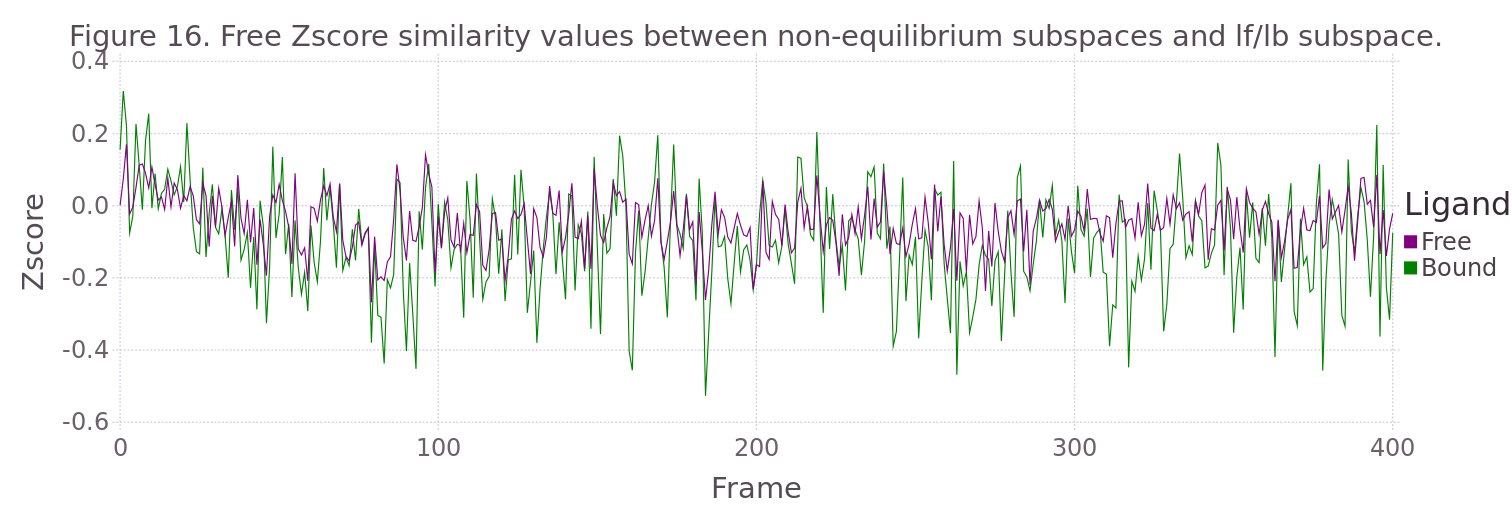

In [135]:
# Compila todo en un dataframe
df_zscore_neq_lf_lb = DataFrame(Zscore = [ zscore_lf_neq; zscore_lb_neq ], Ligand = repeat(["Free"; "Bound"], inner = n_frames),
Frame = [ collect(0:n_frames-1) ; collect(0:n_frames-1)])

# Plot
pdf_Wgramm_neq_lf_lb = plot(df_zscore_neq_lf_lb, x="Frame", y="Zscore", color = "Ligand", Geom.line,
Guide.title("Figure 16. Free Zscore similarity values between non-equilibrium subspaces and lf/lb subspace."),
Scale.color_discrete_manual(colorant"purple", colorant"green"),
Theme( grid_line_width=1pt,
minor_label_font_size = 18pt, major_label_font_size = 22pt, key_title_font_size = 24pt,
key_label_font_size = 18pt))

### Doble ponderación

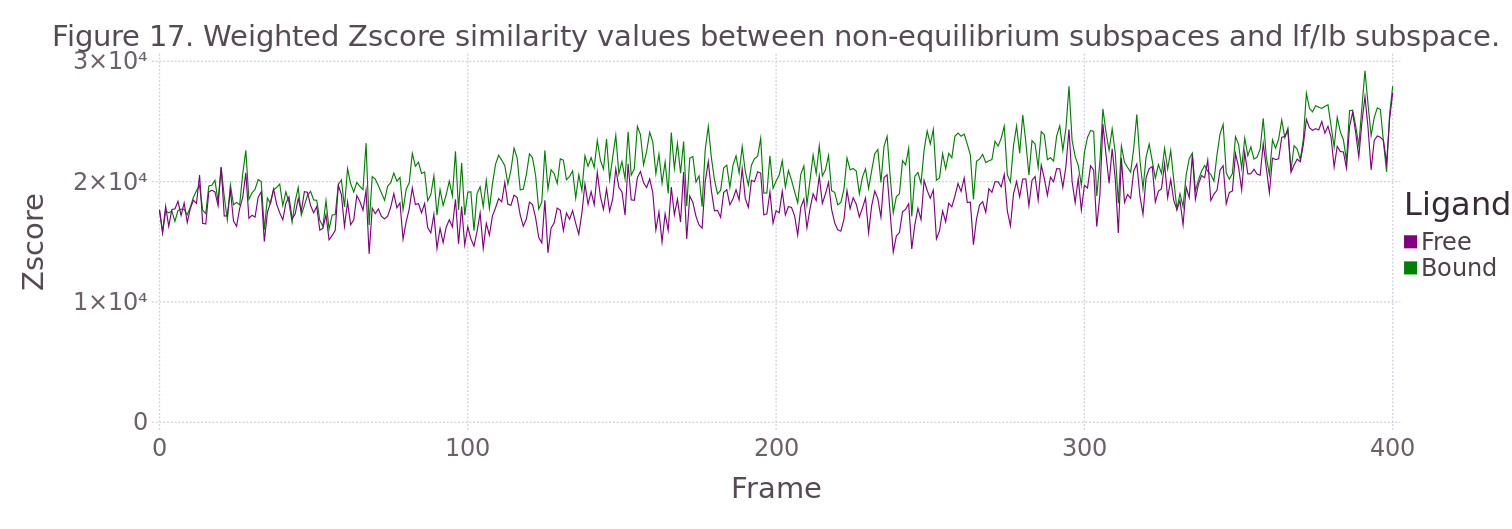

In [136]:
# Compila todo en un dataframe
df_Wzscore_neq_lf_lb = DataFrame(Zscore = [ Wzscore_lf_neq; Wzscore_lb_neq ], Ligand = repeat(["Free"; "Bound"], inner = n_frames),
Frame = [ collect(0:n_frames-1) ; collect(0:n_frames-1)])

# Plot
pdf_Wgramm_neq_lf_lb = plot(df_Wzscore_neq_lf_lb, x="Frame", y="Zscore", color = "Ligand", Geom.line,
Guide.title("Figure 17. Weighted Zscore similarity values between non-equilibrium subspaces and lf/lb subspace."),
Scale.color_discrete_manual(colorant"purple", colorant"green"),
Theme( grid_line_width=1pt,
minor_label_font_size = 18pt, major_label_font_size = 22pt, key_title_font_size = 24pt,
key_label_font_size = 18pt))

### Ponderación simple, con pesos originales

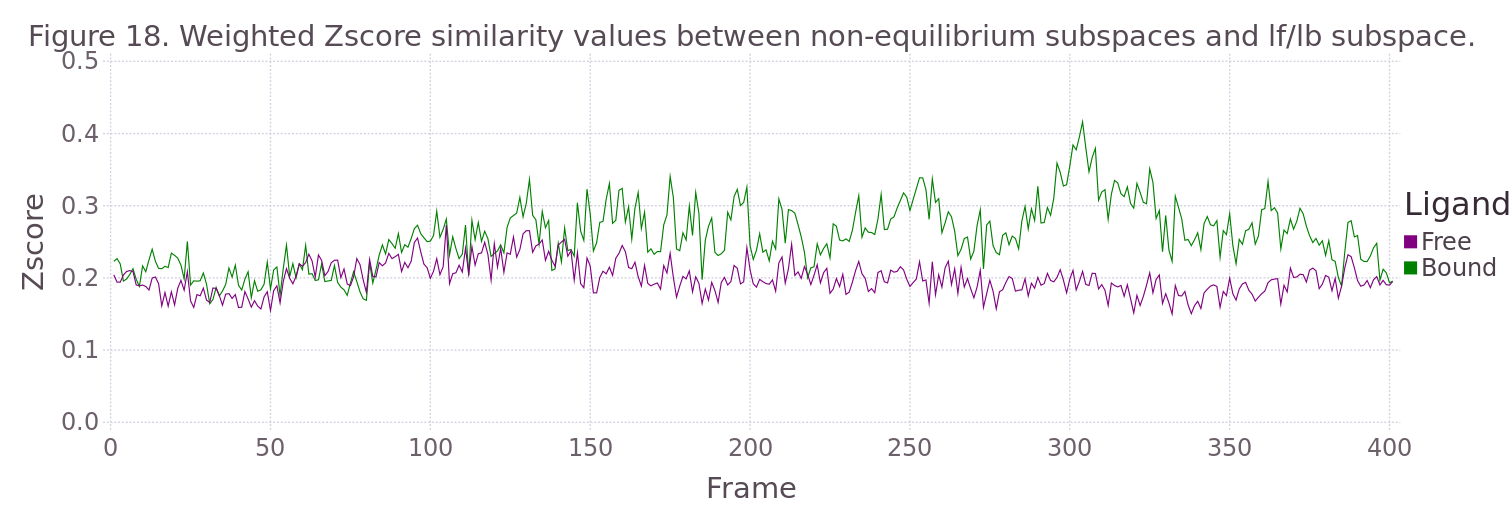

In [115]:
# Compila todo en un dataframe
df_WWzscore_neq_lf_lb = DataFrame(Zscore = [ WWzscore_lf_neq; WWzscore_lb_neq ], Ligand = repeat(["Free"; "Bound"], inner = n_frames),
Frame = [ collect(0:n_frames-1) ; collect(0:n_frames-1)])

# Plot
pdf_WWgramm_neq_lf_lb = plot(df_WWzscore_neq_lf_lb, x="Frame", y="Zscore", color = "Ligand", Geom.line,
Guide.title("Figure 18. Weighted Zscore similarity values between non-equilibrium subspaces and lf/lb subspace."),

Scale.color_discrete_manual(colorant"purple", colorant"green"),
Guide.xticks(ticks = collect(0:50:400)),

Theme(grid_line_width=1pt,
minor_label_font_size = 18pt, major_label_font_size = 22pt, key_title_font_size = 24pt,
key_label_font_size = 18pt))

### Ponderación simple, con pesos random

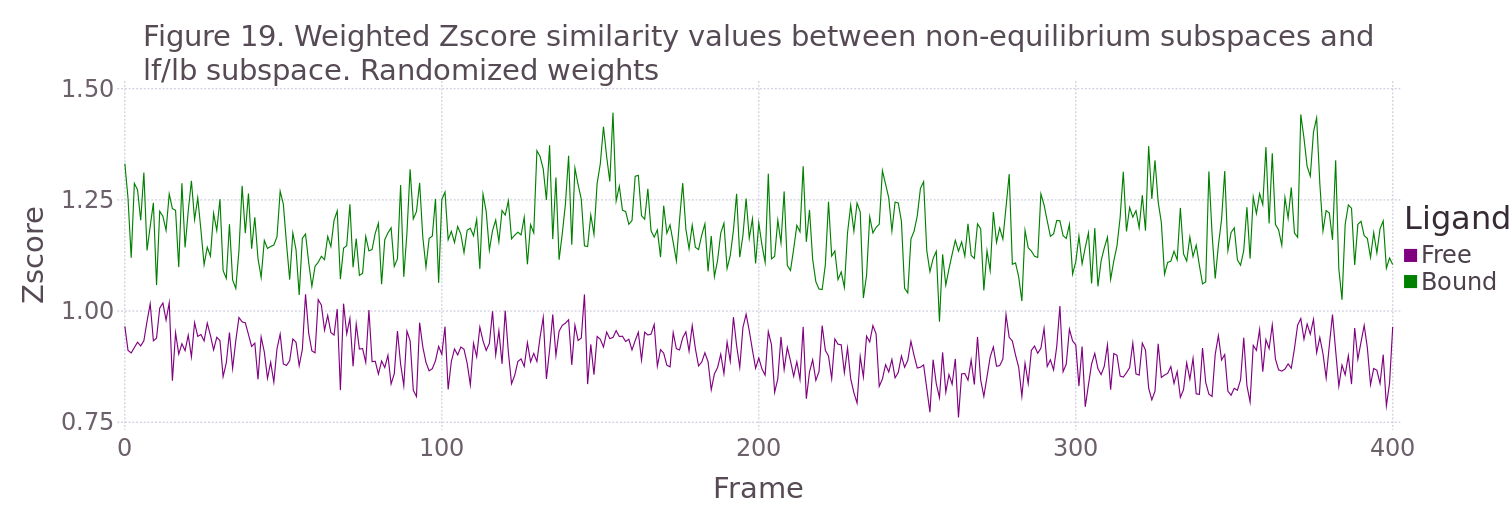

In [137]:
# Compila todo en un dataframe
df_WWzscore_neq_lf_lb_rnd = DataFrame(Zscore = [ WWzscore_lf_neq_rnd; WWzscore_lb_neq_rnd ],
Ligand = repeat(["Free"; "Bound"], inner = n_frames),
Frame = [ collect(0:n_frames-1) ; collect(0:n_frames-1)])

# Plot
pdf_WWgramm_neq_lf_lb_rnd = plot(df_WWzscore_neq_lf_lb_rnd, x="Frame", y="Zscore",
color = "Ligand", Geom.line,

Guide.title("Figure 19. Weighted Zscore similarity values between non-equilibrium subspaces and
lf/lb subspace. Randomized weights"),

Scale.color_discrete_manual(colorant"purple", colorant"green"),
Theme( grid_line_width=1pt,
minor_label_font_size = 18pt, major_label_font_size = 22pt, key_title_font_size = 24pt,
key_label_font_size = 18pt))

## Más gráficos p/ clarificar

### Smooth p/ gráficos finales. Zeta value. Ponderación simple, con pesos originales

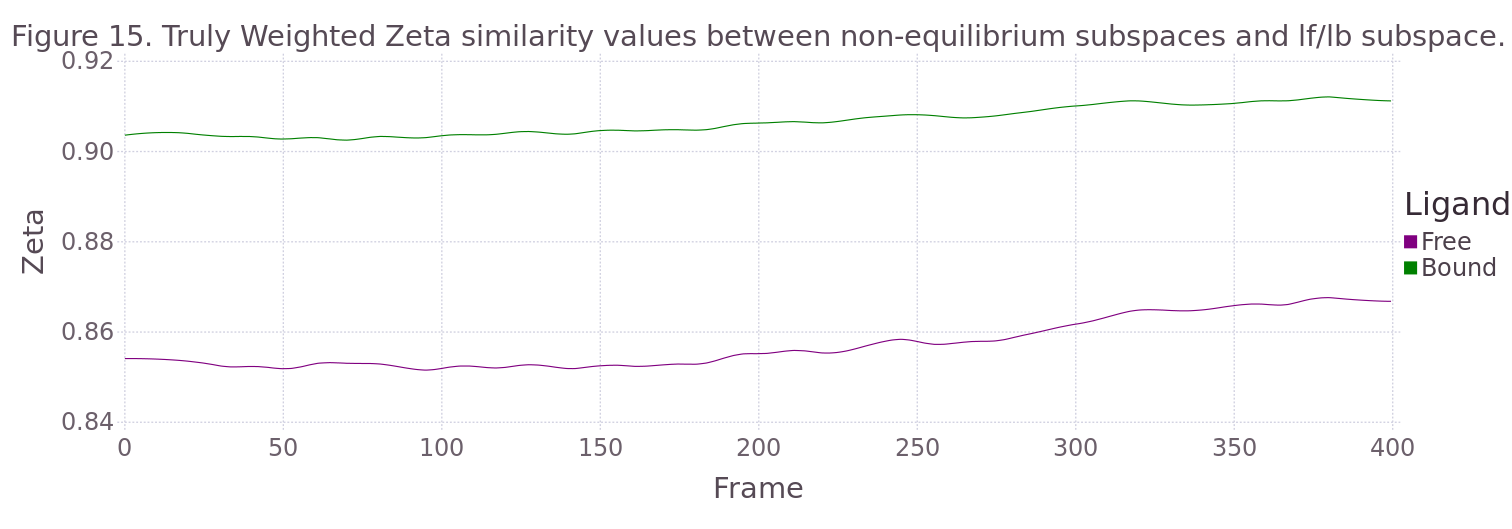

In [117]:
# Plot
pdf_Wgramm_neq_lf_lb = plot(df_WWgramm_neq_lf_lb, x="Frame", y="Zeta", color = "Ligand",
Geom.smooth(method=:loess,smoothing=0.1),
Guide.title("Figure 15. Truly Weighted Zeta similarity values between non-equilibrium subspaces and lf/lb subspace."),
Scale.color_discrete_manual(colorant"purple", colorant"green"),
Guide.xticks(ticks=collect(0:50:400)),
Theme( grid_line_width=1pt,
minor_label_font_size = 18pt, major_label_font_size = 22pt, key_title_font_size = 24pt,
key_label_font_size = 18pt))

### Smooth p/ gráficos finales. Zscore value. Sin ponderación

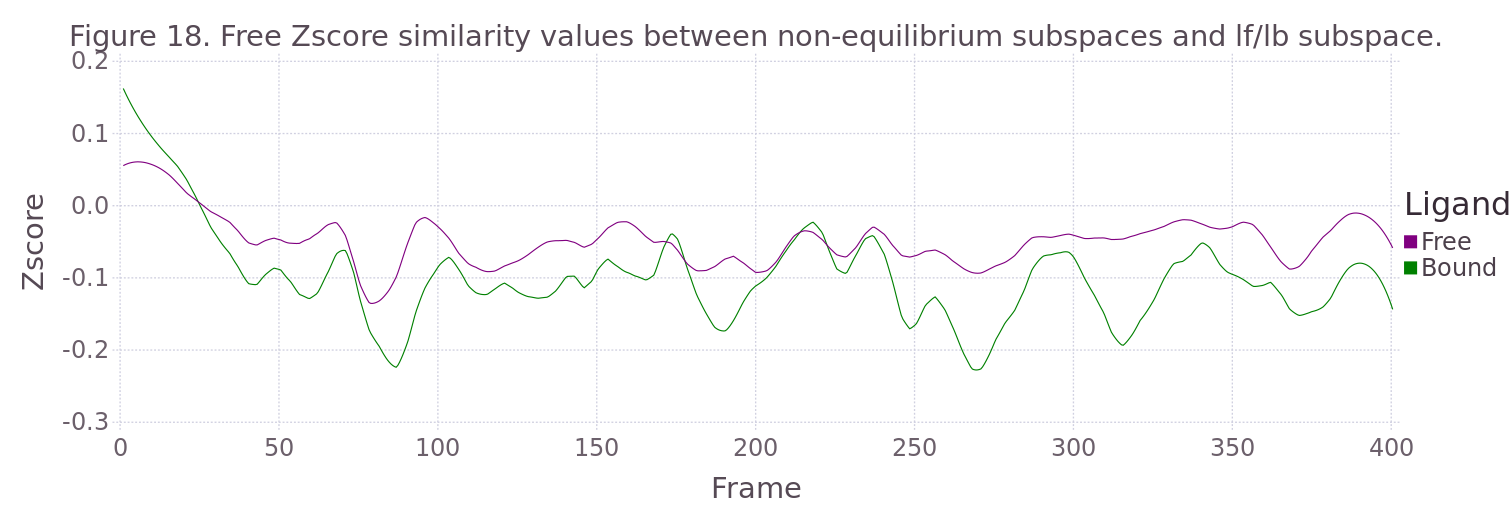

In [118]:
# Plot
pdf_WWgramm_neq_lf_lb = plot(df_zscore_neq_lf_lb, x="Frame", y="Zscore", color = "Ligand",
Geom.smooth(method=:loess,smoothing=0.1),
Guide.title("Figure 18. Free Zscore similarity values between non-equilibrium subspaces and lf/lb subspace."),

Scale.color_discrete_manual(colorant"purple", colorant"green"),
Guide.xticks(ticks = collect(0:50:400)),

Theme( grid_line_width=1pt,
minor_label_font_size = 18pt, major_label_font_size = 22pt, key_title_font_size = 24pt,
key_label_font_size = 18pt))

### Smooth p/ gráficos finales. Zscore. Ponderación simple, con pesos originales

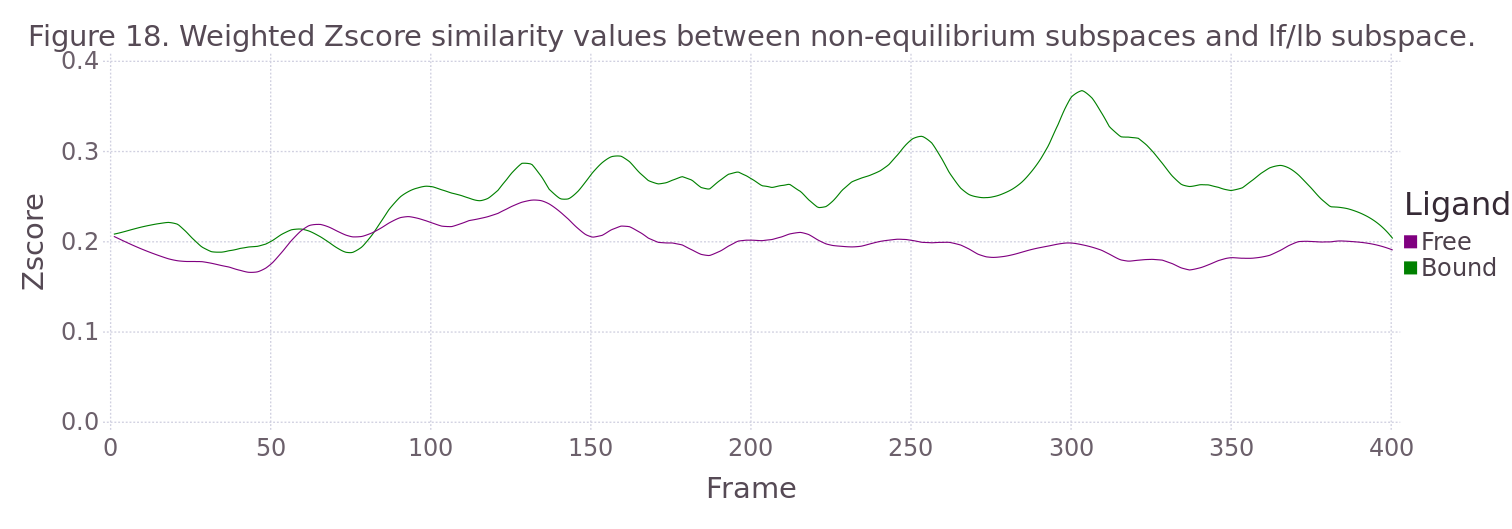

In [119]:
# Plot
pdf_WWgramm_neq_lf_lb = plot(df_WWzscore_neq_lf_lb, x="Frame", y="Zscore", color = "Ligand",
Geom.smooth(method=:loess,smoothing=0.1),
Guide.title("Figure 18. Weighted Zscore similarity values between non-equilibrium subspaces and lf/lb subspace."),

Scale.color_discrete_manual(colorant"purple", colorant"green"),
Guide.xticks(ticks = collect(0:50:400)),

Theme( grid_line_width=1pt,
minor_label_font_size = 18pt, major_label_font_size = 22pt, key_title_font_size = 24pt,
key_label_font_size = 18pt))

## Ponderaciones de modos a lo largo de los frames. 

In [120]:
# Junto las ponderaciones
neq_pond_lo_abs = [ sum(neq_pond_list[i][1:10]) for i=1:n_frames ]
neq_pond_me_abs = [ sum(neq_pond_list[i][11:50]) for i=1:n_frames ]
neq_pond_hi_abs = [ sum(neq_pond_list[i][51:100]) for i=1:n_frames ]

# Relativizo
neq_pond_lo_rel = neq_pond_lo_abs / maximum(neq_pond_lo_abs)
neq_pond_me_rel = neq_pond_me_abs / maximum(neq_pond_me_abs)
neq_pond_hi_rel = neq_pond_hi_abs / maximum(neq_pond_hi_abs)

# Compilo en un dataframe
df_neq_pond_abs = DataFrame(Weight = [ neq_pond_lo_abs ; neq_pond_me_abs ; neq_pond_hi_abs ],
Range = repeat(["Low"; "Medium" ; "High"], inner = n_frames),
Frame = [ collect(1:n_frames) ; collect(1:n_frames) ; collect(1:n_frames)] )

df_neq_pond_rel = DataFrame(Weight = [ neq_pond_lo_rel ; neq_pond_me_rel ; neq_pond_hi_rel ],
Range = repeat(["Low"; "Medium" ; "High"], inner = n_frames),
Frame = [ collect(1:n_frames) ; collect(1:n_frames) ; collect(1:n_frames)] );

### Gráficos con valores absolutos.

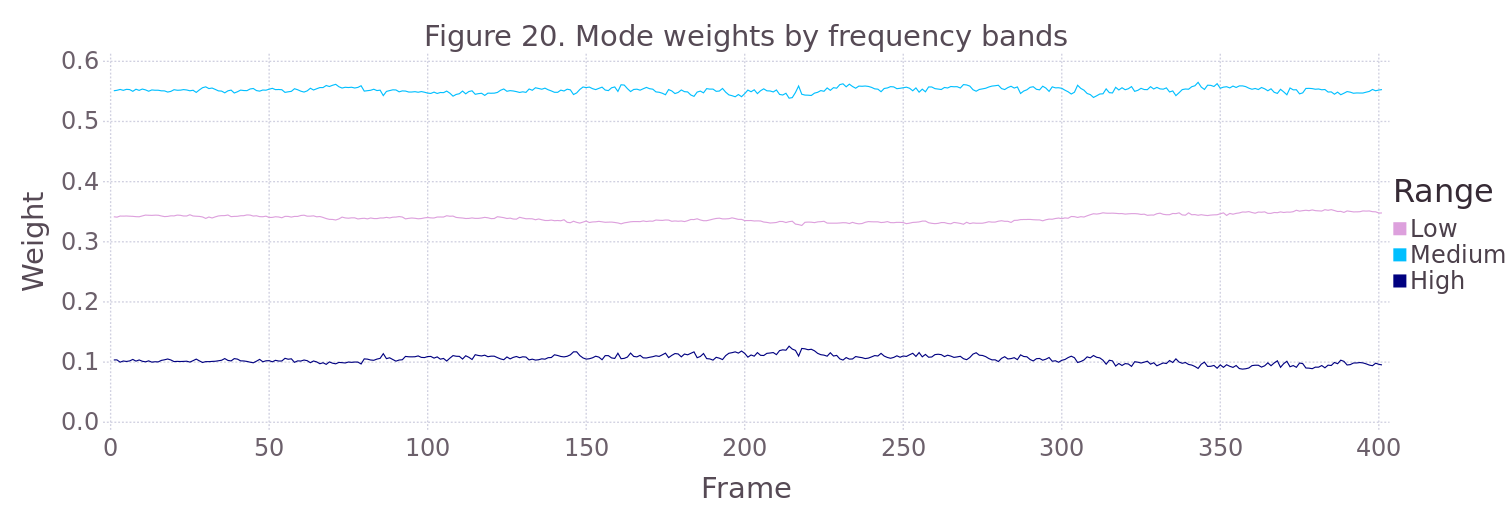

In [121]:
pdf_neq_pond_abs = plot(df_neq_pond_abs, x="Frame", y="Weight",
color = "Range", Geom.line,
Guide.title("Figure 20. Mode weights by frequency bands"),
Scale.color_discrete_manual(colorant"Plum", colorant"DeepSkyBlue", colorant"Navy"),
Guide.xticks(ticks=collect(0:50:400)),
Theme( grid_line_width=1pt,
minor_label_font_size = 18pt, major_label_font_size = 22pt, key_title_font_size = 24pt,
key_label_font_size = 18pt))

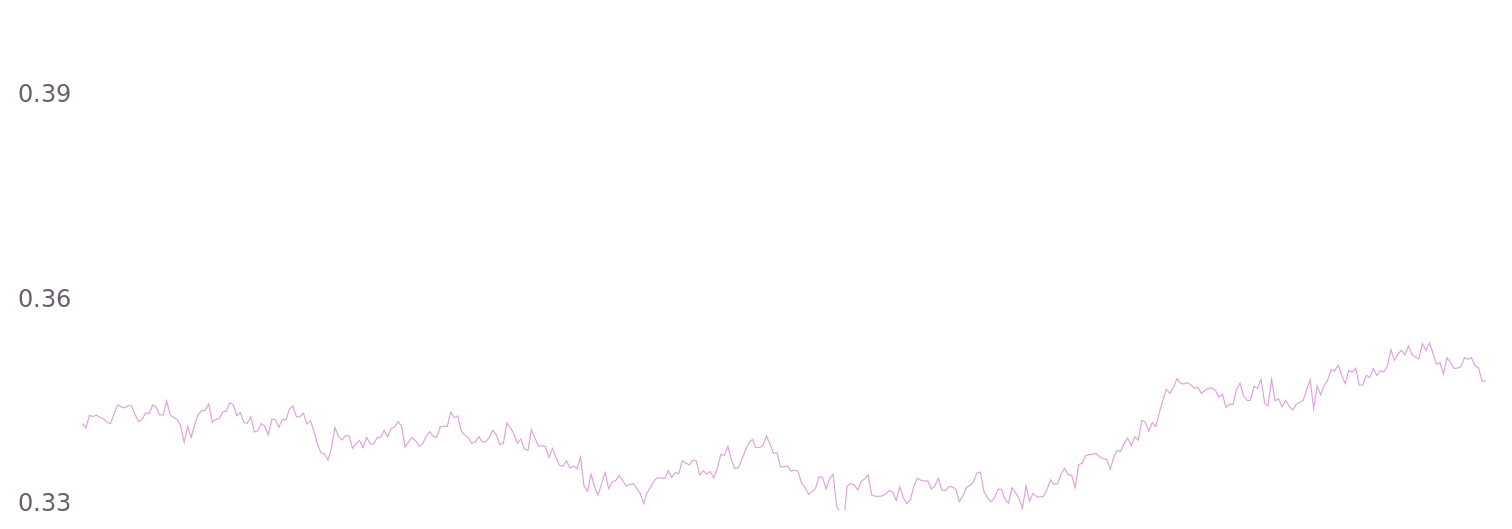

In [122]:
# Compilo en un dataframe
df_neq_pond_lo_abs = DataFrame(Weight = neq_pond_lo_abs,
Range = repeat(["Low"], inner = n_frames),
Frame = collect(1:n_frames))

lay_neq_pond_lo_abs = layer(df_neq_pond_lo_abs, x="Frame", y="Weight",
color = "Range", Geom.line)

pdf_neq_pond_lo_abs = plot(lay_neq_pond_lo_abs,
#Guide.title("Figure 20. Mode weights by frequency bands"),
Scale.color_discrete_manual(colorant"Plum"),
Guide.xticks(ticks=nothing), Guide.xlabel(nothing), Guide.ylabel(nothing),
Guide.yticks(ticks=collect(0.33:0.03:0.4)),
Coord.cartesian(ymin = 0.33, ymax = 0.4),
Theme(grid_line_width=0pt, key_position= :none,
minor_label_font_size = 18pt, major_label_font_size = 22pt, key_title_font_size = 24pt,
key_label_font_size = 18pt))

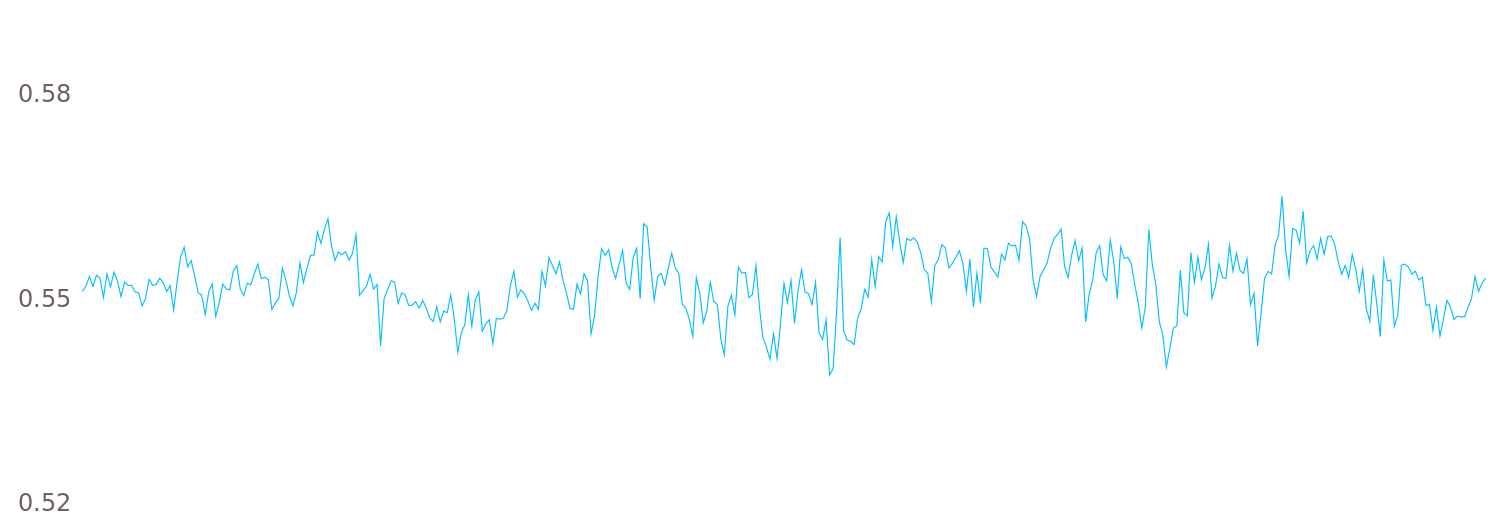

In [123]:
# Compilo en un dataframe
df_neq_pond_me_abs = DataFrame(Weight = neq_pond_me_abs,
Range = repeat(["Medium"], inner = n_frames),
Frame = collect(1:n_frames))

pdf_neq_pond_me_abs = plot(df_neq_pond_me_abs, x="Frame", y="Weight",
color = "Range", Geom.line,
#Guide.title("Figure 20. Mode weights by frequency bands"),
Scale.color_discrete_manual(colorant"DeepSkyBlue"),
Guide.xticks(ticks=nothing), Guide.xlabel(nothing), Guide.ylabel(nothing),
Guide.yticks(ticks=collect(0.52:0.03:0.59)),
Coord.cartesian(ymin = 0.52, ymax = 0.59),
Theme( grid_line_width=0pt, key_position= :none,
minor_label_font_size = 18pt, major_label_font_size = 22pt, key_title_font_size = 24pt,
key_label_font_size = 18pt))

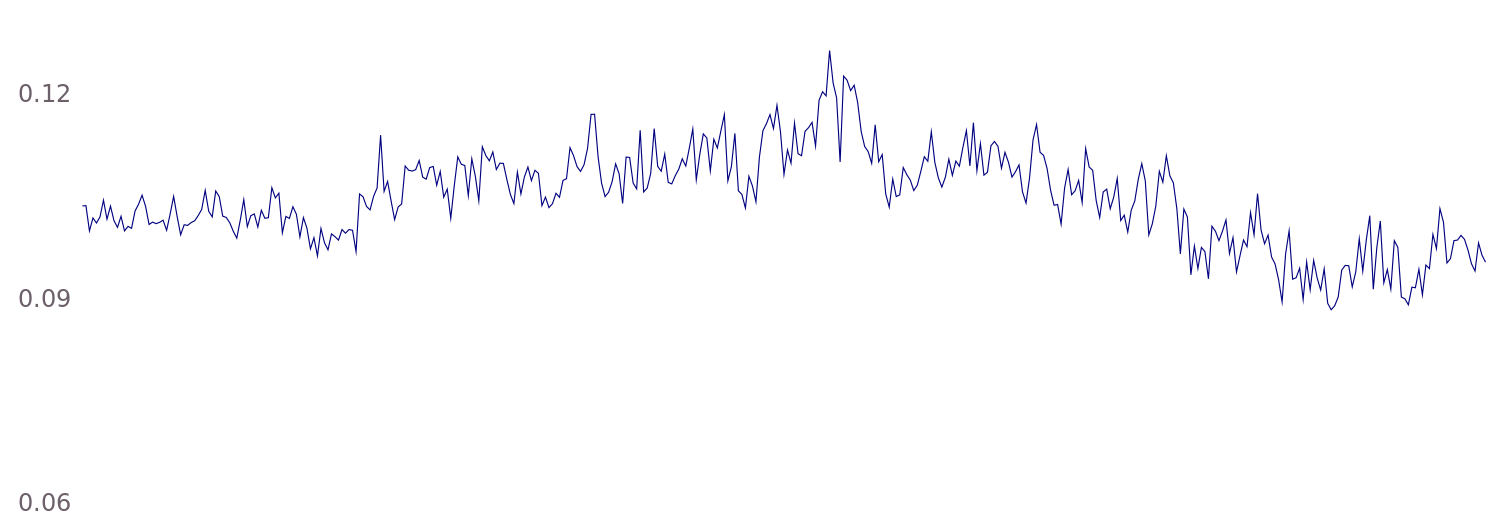

In [124]:
# Compilo en un dataframe
df_neq_pond_hi_abs = DataFrame(Weight = neq_pond_hi_abs,
Range = repeat(["High"], inner = n_frames),
Frame = collect(1:n_frames))

pdf_neq_pond_hi_abs = plot(df_neq_pond_hi_abs, x="Frame", y="Weight",
color = "Range", Geom.line,
Scale.color_discrete_manual(colorant"Navy"),
Guide.xticks(ticks=nothing), Guide.ylabel(nothing),
Guide.xlabel(nothing),
Guide.yticks(ticks=collect(0.06:0.03:0.13)),
Coord.cartesian(ymin = 0.06, ymax = 0.13),
Theme( grid_line_width=0pt, key_position= :none,
minor_label_font_size = 18pt, major_label_font_size = 22pt, key_title_font_size = 24pt,
key_label_font_size = 18pt))

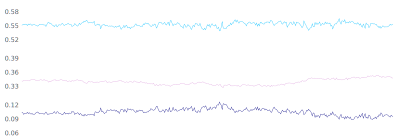

In [125]:
pdf_neq_pond_abs_stacked = vstack(pdf_neq_pond_me_abs, pdf_neq_pond_lo_abs, pdf_neq_pond_hi_abs)

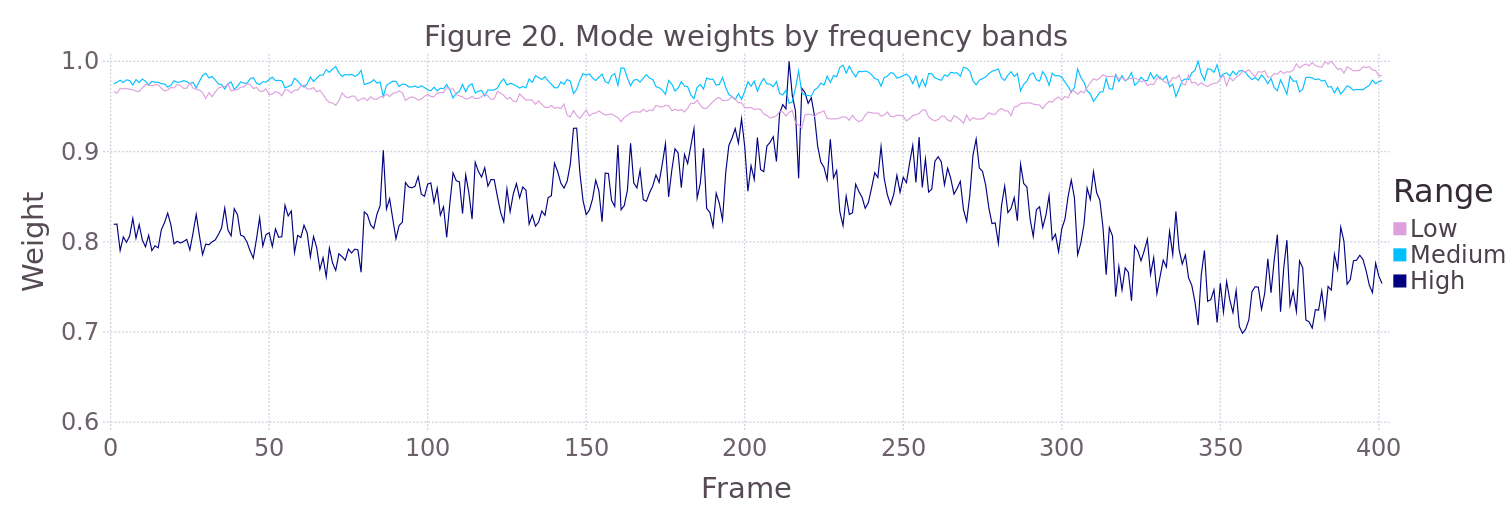

In [126]:
pdf_neq_pond_rel = plot(df_neq_pond_rel, x="Frame", y="Weight",
color = "Range", Geom.line,
Guide.title("Figure 20. Mode weights by frequency bands"),
Scale.color_discrete_manual(colorant"Plum", colorant"DeepSkyBlue", colorant"Navy"),
Guide.xticks(ticks=collect(0:50:400)),
Theme( grid_line_width=1pt,
minor_label_font_size = 18pt, major_label_font_size = 22pt, key_title_font_size = 24pt,
key_label_font_size = 18pt))

### Gráficos con valores relativos.

In [127]:
# Relativizo
neq_pond_lo_rel = neq_pond_lo_abs / neq_pond_lo_abs[1]
neq_pond_me_rel = neq_pond_me_abs / neq_pond_me_abs[1]
neq_pond_hi_rel = neq_pond_hi_abs / neq_pond_hi_abs[1]

df_neq_pond_rel = DataFrame(Weight = [ neq_pond_lo_rel ; neq_pond_me_rel ; neq_pond_hi_rel ],
Range = repeat(["Low"; "Medium" ; "High"], inner = n_frames),
Frame = [ collect(1:n_frames) ; collect(1:n_frames) ; collect(1:n_frames)] );

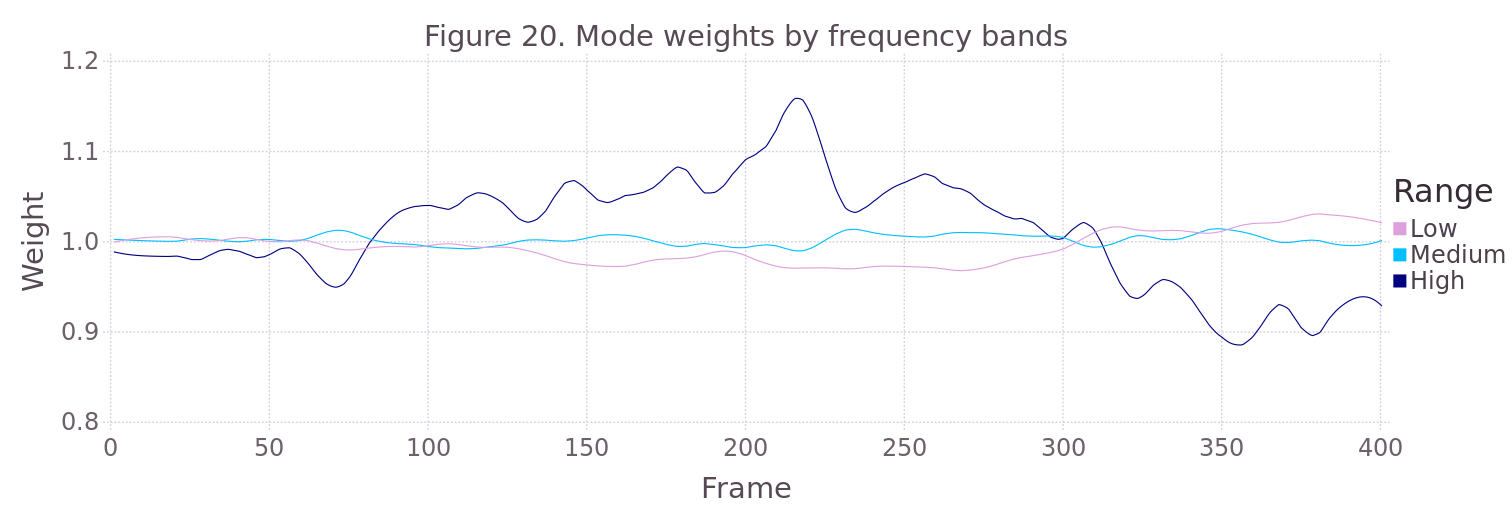

In [128]:
pdf_neq_pond_rel_smooth = plot(df_neq_pond_rel, x="Frame", y="Weight", color = "Range",
Geom.smooth(method=:loess,smoothing=0.1),
Guide.title("Figure 20. Mode weights by frequency bands"),
Scale.color_discrete_manual(colorant"Plum", colorant"DeepSkyBlue", colorant"Navy"),
Guide.xticks(ticks=collect(0:50:400)), 
Theme( grid_line_width=1pt,
minor_label_font_size = 18pt, major_label_font_size = 22pt, key_title_font_size = 24pt,
key_label_font_size = 18pt))

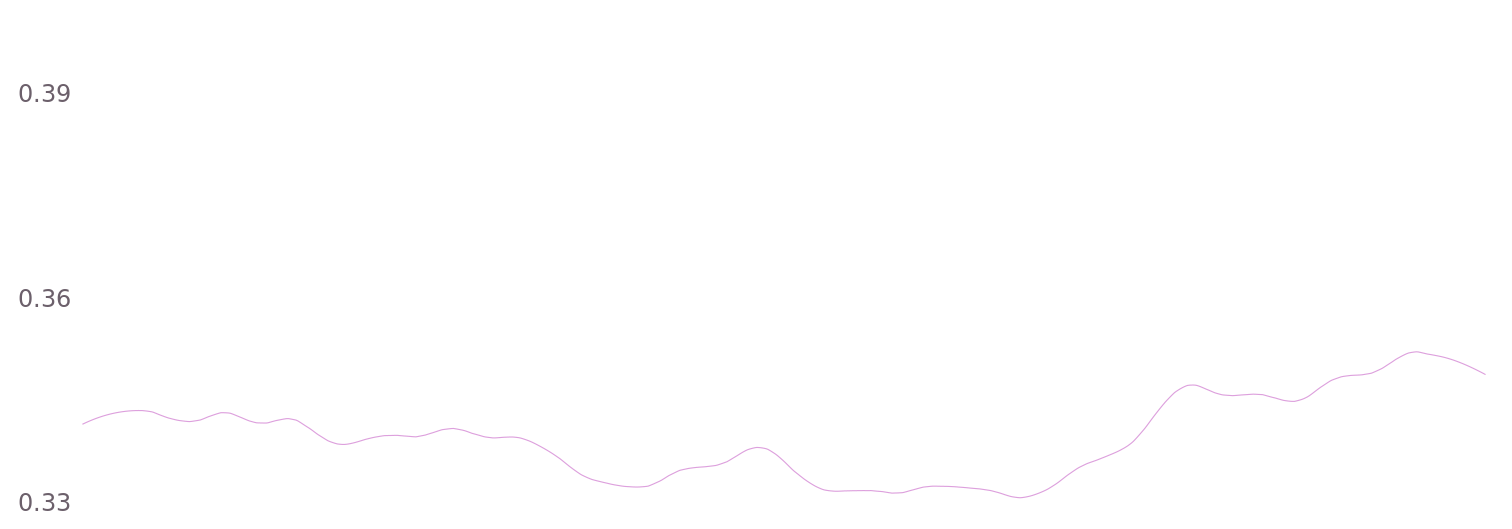

In [129]:
pdf_neq_pond_lo_abs = plot(df_neq_pond_lo_abs, x="Frame", y="Weight", color = "Range",
Geom.smooth(method=:loess,smoothing=0.1),
#Guide.title("Figure 20. Mode weights by frequency bands"),
Scale.color_discrete_manual(colorant"Plum"),
Guide.xticks(ticks=nothing), Guide.ylabel(nothing),  Guide.xlabel(nothing),
Guide.yticks(ticks=collect(0.33:0.03:0.4)),
Coord.cartesian(ymin = 0.33, ymax = 0.4),
Scale.y_continuous(minvalue=0.33, maxvalue=0.4),
Theme( grid_line_width=0pt, key_position= :none,
minor_label_font_size = 18pt, major_label_font_size = 22pt, key_title_font_size = 24pt,
key_label_font_size = 18pt))

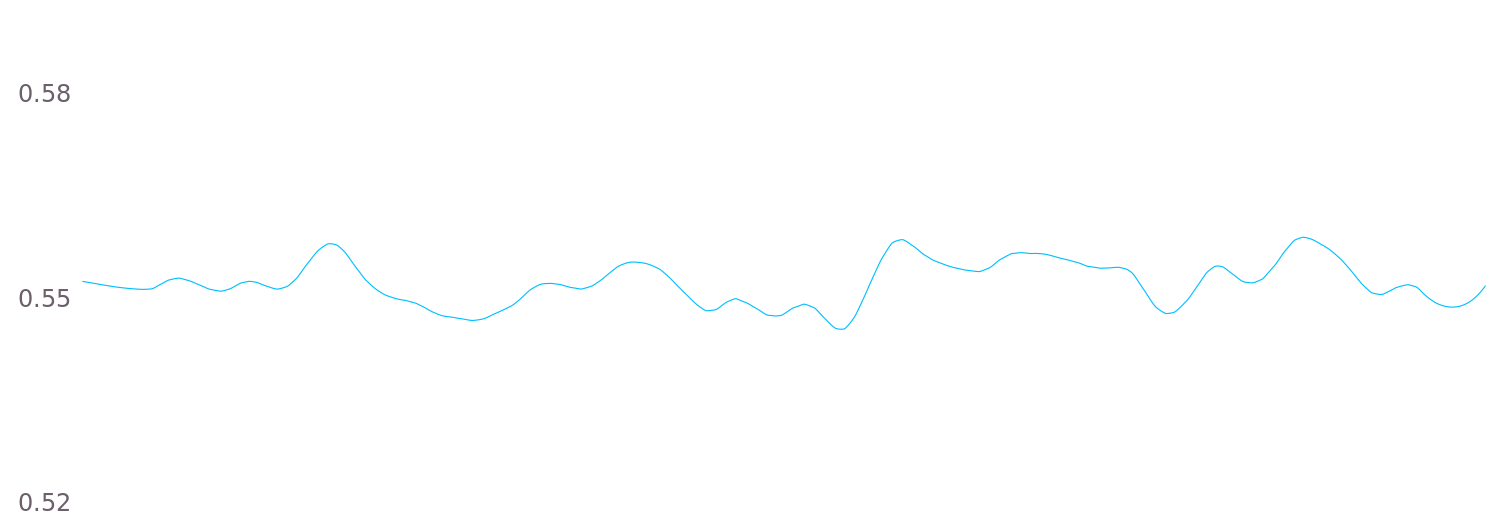

In [130]:
pdf_neq_pond_me_abs = plot(df_neq_pond_me_abs, x="Frame", y="Weight", color = "Range",
Geom.smooth(method=:loess,smoothing=0.1),
#Guide.title("Figure 20. Mode weights by frequency bands"),
Scale.color_discrete_manual(colorant"DeepSkyBlue"),
Guide.xticks(ticks=nothing), Guide.ylabel(nothing), Guide.xlabel(nothing),
Guide.yticks(ticks=collect(0.52:0.03:0.59)),
Coord.cartesian(ymin = 0.52, ymax = 0.59),
Scale.y_continuous(minvalue=0.52, maxvalue=0.59),
Theme( grid_line_width=0pt, key_position= :none,
minor_label_font_size = 18pt, major_label_font_size = 22pt, key_title_font_size = 24pt,
key_label_font_size = 18pt))

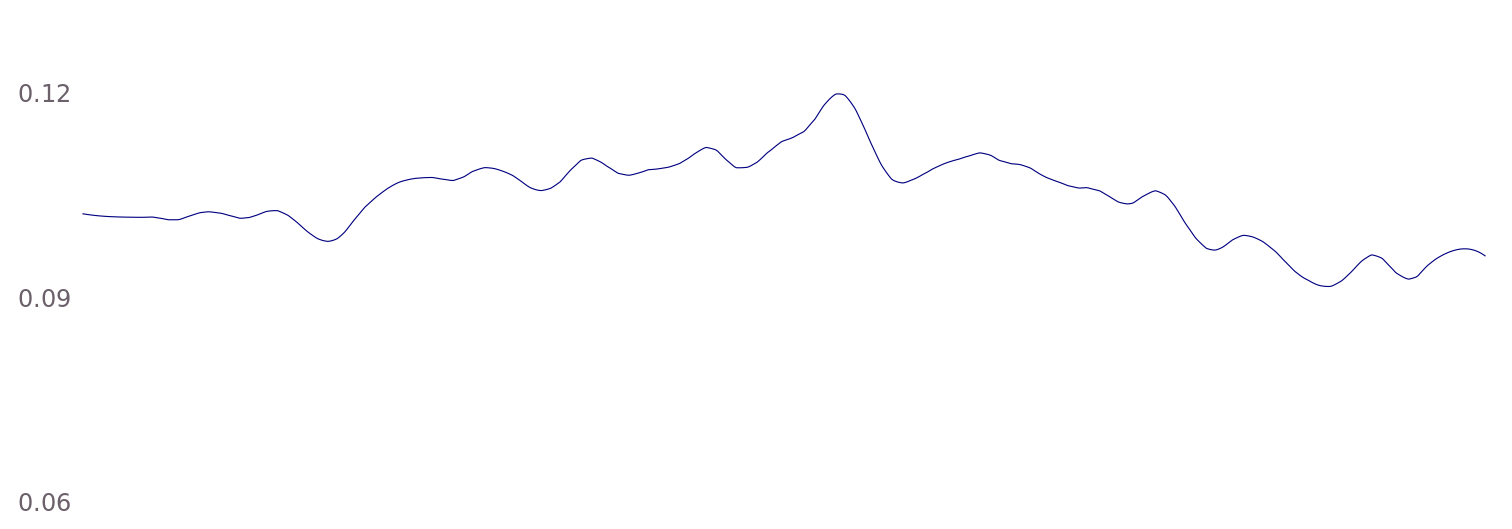

In [131]:
pdf_neq_pond_hi_abs = plot(df_neq_pond_hi_abs, x="Frame", y="Weight", color = "Range",
Geom.smooth(method=:loess,smoothing=0.1),
#Guide.title("Figure 20. Mode weights by frequency bands"),
Scale.color_discrete_manual(colorant"Navy"),
Guide.xticks(ticks=nothing), Guide.xlabel(nothing), 
Guide.yticks(ticks=collect(0.06:0.03:0.13)), Guide.ylabel(nothing),
Coord.cartesian(ymin = 0.06, ymax = 0.13),
Scale.y_continuous(minvalue=0.06, maxvalue=0.13),
Theme( grid_line_width=0pt, key_position= :none,
minor_label_font_size = 18pt, major_label_font_size = 22pt, key_title_font_size = 24pt,
key_label_font_size = 18pt))

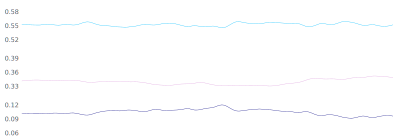

In [132]:
pdf_neq_pond_abs_stacked_smooth = vstack(pdf_neq_pond_me_abs, pdf_neq_pond_lo_abs, pdf_neq_pond_hi_abs)

### Veo modos con mayor variación

In [176]:
avrg = zeros(Float64, 100)
top = zeros(Float64, 100)
low = repeat([1.0], inner = [100])
ind_top = Array{Int64}(100)
ind_low = Array{Int64}(100)

for i = 1:n_frames
    for j = 1:100
        
        avrg[j] = avrg[j] + neq_pond_list[i][j]
        if neq_pond_list[i][j] > top[j]
            top[j] = neq_pond_list[i][j]
            ind_top[j] = i
        end
        
        if neq_pond_list[i][j] < low[j]
            low[j] = neq_pond_list[i][j]
            ind_low[j] = i
        end
    end
end
delta_sign = top - low;
delta = abs(top - low);
avrg = avrg ./ n_frames;
delta_rel = delta ./ avrg;

In [177]:
ind_low

100-element Array{Int64,1}:
 260
 150
 209
  53
 381
 175
 284
 247
 237
  72
  59
 299
  48
   ⋮
  96
 112
  29
 103
  18
   2
  29
  59
  16
   3
  10
   9

In [172]:
delta_sign[15:35]

21-element Array{Float64,1}:
 0.00502082
 0.00886429
 0.0192571 
 0.00753433
 0.0177374 
 0.0195086 
 0.0124015 
 0.0165434 
 0.0292609 
 0.023744  
 0.0284973 
 0.0227307 
 0.015078  
 0.0206305 
 0.013187  
 0.00890245
 0.0111887 
 0.0185046 
 0.0168597 
 0.0191504 
 0.0184132 

In [173]:
delta_sign

100-element Array{Float64,1}:
 0.00531662
 0.00512434
 0.00412555
 0.00626364
 0.00499319
 0.00581791
 0.00878012
 0.00893682
 0.00819109
 0.008882  
 0.0106962 
 0.0077836 
 0.00531207
 ⋮         
 0.0032268 
 0.00298285
 0.00339083
 0.00274683
 0.00249926
 0.00215916
 0.00210116
 0.0020564 
 0.00213773
 0.00191599
 0.00218001
 0.00213806

In [163]:
sortperm(delta_rel, rev = true)

100-element Array{Int64,1}:
  99
  98
 100
  97
  86
  82
  80
  92
  94
  95
  89
  87
  81
   ⋮
  10
   8
   7
   9
  15
  13
   4
   6
   5
   2
   3
   1

In [169]:
sortperm(delta, rev = true)

100-element Array{Int64,1}:
  23
  25
  24
  26
  28
  20
  17
  34
  36
  32
  35
  19
  33
   ⋮
  84
  87
  92
  88
  93
  99
  94
 100
  97
  95
  96
  98

In [146]:
top[1]

0.052582883577486514

In [160]:
neq_pond_list[10][1:100]

100-element Array{Float64,1}:
 0.0522584  
 0.0394635  
 0.0394635  
 0.0322183  
 0.0334515  
 0.0343764  
 0.0306767  
 0.028981   
 0.0265146  
 0.0255896  
 0.0235856  
 0.0258979  
 0.0232773  
 ⋮          
 0.000616618
 0.000770772
 0.000616618
 0.000924927
 0.000308309
 0.000462463
 0.000462463
 0.000770772
 0.000462463
 0.000616618
 0.0        
 0.000154154

In [150]:
neq_pond_list

401-element Array{Array{Float64,1},1}:
 [0.0521188,0.0383545,0.0378905,0.0327869,0.0340241,0.0338695,0.0317043,0.0290752,0.0255181,0.0262914  …  0.0,0.000154655,0.000154655,0.000154655,0.0,0.0,0.0,0.0,0.0,0.000154655]                               
 [0.0519802,0.038521,0.0382116,0.0321782,0.03388,0.0340347,0.0317141,0.0289295,0.025526,0.0259901  …  0.000154703,0.000309406,0.000309406,0.000154703,0.0,0.0,0.0,0.0,0.000309406,0.000154703]                   
 [0.0524519,0.0387958,0.0387958,0.0325885,0.0333644,0.0346058,0.0318125,0.0282433,0.0256052,0.0265363  …  0.000155183,0.000155183,0.000155183,0.000155183,0.0,0.000310366,0.000310366,0.0,0.0,0.0]               
 [0.0524763,0.0386586,0.0386586,0.0329141,0.0338457,0.0343114,0.0316721,0.0282565,0.0259277,0.0259277  …  0.000310511,0.000310511,0.000465766,0.000465766,0.000155255,0.0,0.0,0.0,0.000155255,0.000465766]       
 [0.0521011,0.0389208,0.0384556,0.0333385,0.034579,0.0351993,0.0305474,0.0280664,0.0258955,0.0257404  …  0.000310126,0.00

## Output plots

In [133]:
draw(PNG(string(main_dir, rtdos_dir, "short_min_cost_20_temp_evo_abs_stacked.png"), 20cm, 10cm), pdf_neq_pond_abs_stacked)
draw(PNG(string(main_dir, rtdos_dir, "short_min_cost_20_temp_evo_rel.png"), 20cm, 10cm), pdf_neq_pond_rel)

draw(PNG(string(main_dir, rtdos_dir, "short_min_cost_20_temp_evo_abs_stacked_smooth.png"), 20cm, 10cm), pdf_neq_pond_abs_stacked_smooth)
draw(PNG(string(main_dir, rtdos_dir, "short_min_cost_20_temp_evo_rel_smooth.png"), 20cm, 10cm), pdf_neq_pond_rel_smooth)